In [1]:
%matplotlib inline

# Packages
import os, glob, scipy, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Project directory
base_dir = os.path.realpath('..')
print(base_dir)

# Project-specific functions
funDir = os.path.join(base_dir,'Code/Functions')
print(funDir)
sys.path.append(funDir)
import choiceModels, costFunctions, penalizedModelFit, simulateModel

# General-use python functions
dbPath = '/'.join(base_dir.split('/')[0:4])
sys.path.append('%s/Python'%dbPath)
import FigureTools

/Users/jeroen/Dropbox (Brown)/PhD/0. Working folder/HMTG_followUp_final/ShareDataCode
/Users/jeroen/Dropbox (Brown)/PhD/0. Working folder/HMTG_followUp_final/ShareDataCode/Code/Functions


## Choose set

#### Select subs who are constant in their study 1 cluster

In [18]:
study = 1
clusters_4 = pd.read_csv(os.path.join(base_dir,'Data/Study1/ComputationalModel',
                'ParamsClusters_study-1_baseMult-4_model-MP_ppSOE_precision-100.csv'),index_col=0)[
    ['sub','ClustName']]
clusters_6 = pd.read_csv(os.path.join(base_dir,'Data/Study1/ComputationalModel',
                'ParamsClusters_study-1_baseMult-6_model-MP_ppSOE_precision-100.csv'),index_col=0)[
    ['sub','ClustName']]
exclude = np.array(pd.read_csv(os.path.join(base_dir,'Data/Study1/HMTG/exclude.csv'),index_col=None,header=None).T)[0]
clusters = clusters_4.merge(clusters_6,on='sub')
clusters = clusters.loc[~clusters['sub'].isin(exclude)]
clusters.columns = ['sub','x4','x6']
clusters['stable'] = 1*(clusters['x4']==clusters['x6'])
clusters.head()
clusters = clusters[['sub','x4','stable']]
clusters.columns = ['sub','cluster','stable']
clusters_study2 = pd.read_csv(os.path.join(base_dir,'Data/Study2/ComputationalModel',
                'ParamsClusters_study-2_model-MP_ppSOE_precision-100.csv'),index_col=0)[
    ['sub','ClustName']]
exclude = np.array(pd.read_csv(os.path.join(base_dir,'Data/Study2/HMTG/exclude.csv'),index_col=0,header=0).T)[0]
clusters_study2 = clusters_study2.loc[~clusters_study2['sub'].isin(exclude)]
clusters_study2.columns = ['sub','cluster']
clusters_study2['stable'] = 1
clusters = clusters.append(clusters_study2)
clusters.head()

,sub,cluster,stable
0,1,MO,1
1,2,GR,1
2,3,MO,0
3,4,IA,1
4,5,IA,1


In [19]:
## Load additional measures
allScores = pd.read_csv(os.path.join(base_dir,
            'Data/Study%i/AllScores/allScores.csv'%1),index_col=0).append(
            pd.read_csv(os.path.join(base_dir,
            'Data/Study%i/AllScores/allScores.csv'%2),index_col=0))
allScores = allScores[['sub','SVO_score','SVO_prosocial','DGS_score','TG_score']]
allScores.columns = ['sub','SVO','Prosocial','DG','TG']

## Load model params
params_1 = pd.read_csv(os.path.join(base_dir,'Data/Study1/ComputationalModel',
                            'ParamsClusters_study-1_baseMult-4_model-%s_precision-%i.csv'%(
                            'MP_ppSOE',100)),index_col=0).append(
            pd.read_csv(os.path.join(base_dir,'Data/Study1/ComputationalModel',
                            'ParamsClusters_study-1_baseMult-6_model-%s_precision-%i.csv'%(
                            'MP_ppSOE',100)),index_col=0))
params_1 = params_1.groupby('sub').apply(np.mean).reset_index(drop=True)[['sub','theta','phi']]
params_2 = pd.read_csv(os.path.join(base_dir,'Data/Study2/ComputationalModel',
                            'ParamsClusters_study-2_model-%s_precision-%i.csv'%(
                            'MP_ppSOE',100)),index_col=0)[['sub','theta','phi']]
params_use = params_1.append(params_2).reset_index(drop=True)

### Merge with clustering and additional measures
params_use = clusters.merge(params_use,on='sub').merge(allScores,on='sub')
params_use = params_use.loc[params_use['stable']==1]
params_use = params_use[['sub','theta','phi','cluster','SVO','Prosocial','DG','TG']]
params_use.head()
subNums = np.unique(params_use['sub'])
print (len(subNums))

129


## Plot

theta with SVO: r = -0.68, p = 0.0000
theta with DG: r = 0.21, p = 0.0172
theta with TG: r = 0.05, p = 0.6069
phi with SVO: r = 0.24, p = 0.0063
phi with DG: r = -0.17, p = 0.0564
phi with TG: r = -0.06, p = 0.5208


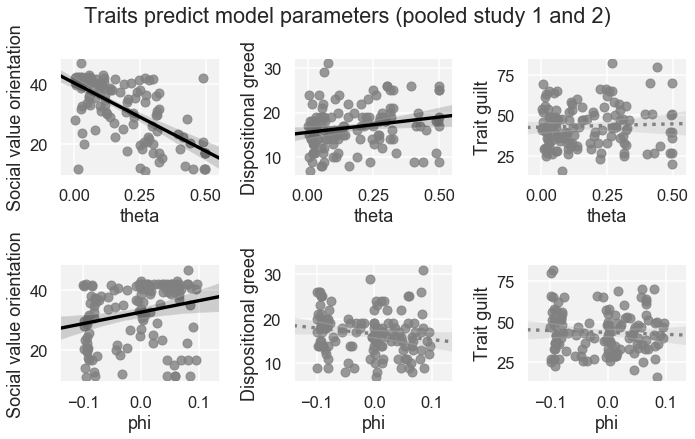

In [32]:
FigureTools.mydesign(context='talk')
fig, ax = plt.subplots(2,3,figsize=[10,6])
longNames = {'SVO':'Social value orientation','DG':'Dispositional greed','TG':'Trait guilt'}
for paramInd,parameter in enumerate(['theta','phi']):
    for metricInd,metric in enumerate(['SVO','DG','TG']):
        stats = scipy.stats.pearsonr(params_use[parameter],params_use[metric])
        if stats[1] < 0.05:
            linestyle = '-'
            color = 'k'
        else:
            linestyle = ':'
            color = 'grey'
        sns.regplot(data=params_use,x=parameter,y=metric,ax=ax[paramInd,metricInd],
                    color='grey',line_kws={'color':color,'linestyle':linestyle})
        print ('%s with %s: r = %.2f, p = %.4f'%(parameter,metric,stats[0],stats[1]))
        ax[paramInd,metricInd].set(ylabel=longNames[metric])
plt.tight_layout()
plt.suptitle('Traits predict model parameters (pooled study 1 and 2)',y=1.03)
plt.show()

#### By cluster

SVO: F = 26.13, p = 0.0000
GR with GA: t = -4.50, p = 0.0001, p_corr = 0.0006
IA with MO: t = 5.12, p = 0.0000, p_corr = 0.0000
GR with IA: t = -11.98, p = 0.0000, p_corr = 0.0000
GR with MO: t = -4.95, p = 0.0000, p_corr = 0.0000
GA with IA: t = -3.41, p = 0.0013, p_corr = 0.0077
GA with MO: t = 0.60, p = 0.5490, p_corr = 3.2941
DG: F = 1.75, p = 0.1594
TG: F = 0.26, p = 0.8510


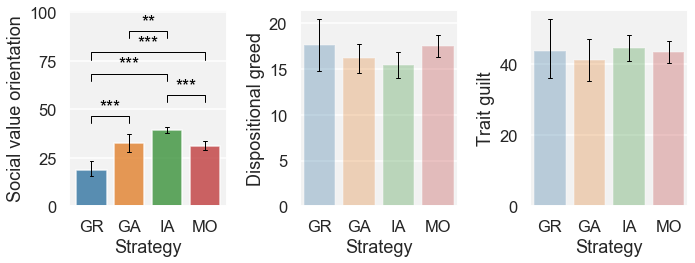

In [22]:
FigureTools.mydesign(context='talk')
sns.set_palette('tab10')
groupList = ['GR','GA','IA','MO']
fig, ax = plt.subplots(1,3,figsize=[10,4])
longNames = {'SVO':'Social value orientation','DG':'Dispositional greed','TG':'Trait guilt'}
for metricInd,metric in enumerate(['SVO','DG','TG']):
    samples = [params_use.loc[params_use['cluster']==groupList[i],metric] for i in range(len(groupList))]
    stats = scipy.stats.f_oneway(params_use.loc[params_use['cluster']==groupList[0],metric],
                                params_use.loc[params_use['cluster']==groupList[1],metric],
                                params_use.loc[params_use['cluster']==groupList[2],metric],
                                params_use.loc[params_use['cluster']==groupList[3],metric])
    if stats[1] < 0.05:
        alpha = .8
    else:
        alpha = .3
    sns.barplot(data=params_use,x='cluster',y=metric,ax=ax[metricInd],
                order = groupList,
                alpha=alpha,errwidth=1,errcolor='k',capsize=.1)
    print ('%s: F = %.2f, p = %.4f'%(metric,stats[0],stats[1]))
    ax[metricInd].set(ylabel=longNames[metric],xlabel='Strategy')
    if metric == 'SVO':
        sampleCouples = [[0,1],[2,3],[0,2],[0,3],[1,2],[1,3]]
        signCouples = list()
        for couple in sampleCouples:
            stats = scipy.stats.ttest_ind(samples[couple[0]],samples[couple[1]])
            print ('%s with %s: t = %.2f, p = %.4f, p_corr = %.4f'%(
                groupList[couple[0]],groupList[couple[1]],stats[0],stats[1],stats[1]*len(sampleCouples)))
            if stats[1]*len(sampleCouples) < 0.05:
                signCouples = signCouples+[np.hstack([couple,stats[1]*len(sampleCouples)])]
        FigureTools.add_sig_markers(ax[metricInd],relationships=signCouples,distScale=.6)
plt.tight_layout()
plt.show()

## Residualize phi

In [23]:
scipy.stats.pearsonr(params_use['theta'],params_use['phi'])

(-0.3119113952580276, 0.0003202412225637789)

In [24]:
from scipy.stats import linregress

In [25]:
out = linregress(params_use['theta'], params_use['phi'])

In [26]:
out.slope

-0.13130089011008084

In [27]:
out.intercept

0.013514169055540292

In [28]:
phi_resid = params_use['phi'].values - (params_use['theta'].values*out.slope + out.intercept)

In [29]:
params_use['Phi (residualized)'] = phi_resid

In [30]:
scipy.stats.pearsonr(params_use['theta'],params_use['Phi (residualized)'])

(-8.153200337090993e-17, 0.9999999999999912)

## Both

theta with SVO: r = -0.68, p = 0.0000
theta with DG: r = 0.21, p = 0.0172
theta with TG: r = 0.05, p = 0.6069
phi with SVO: r = 0.03, p = 0.7356
phi with DG: r = -0.11, p = 0.2209
phi with TG: r = -0.05, p = 0.6124
SVO: F = 26.13, p = 0.0000
GR with GA: t(30) = -4.50, p = 0.0001, p_corr = 0.0006
IA with MO: t(97) = 5.12, p = 0.0000, p_corr = 0.0000
GA with IA: t(53) = -3.41, p = 0.0013, p_corr = 0.0077
GR with IA: t(54) = -11.98, p = 0.0000, p_corr = 0.0000
GR with MO: t(74) = -4.95, p = 0.0000, p_corr = 0.0000
GA with MO: t(73) = 0.60, p = 0.5490, p_corr = 3.2941
DG: F = 1.75, p = 0.1594
TG: F = 0.26, p = 0.8510


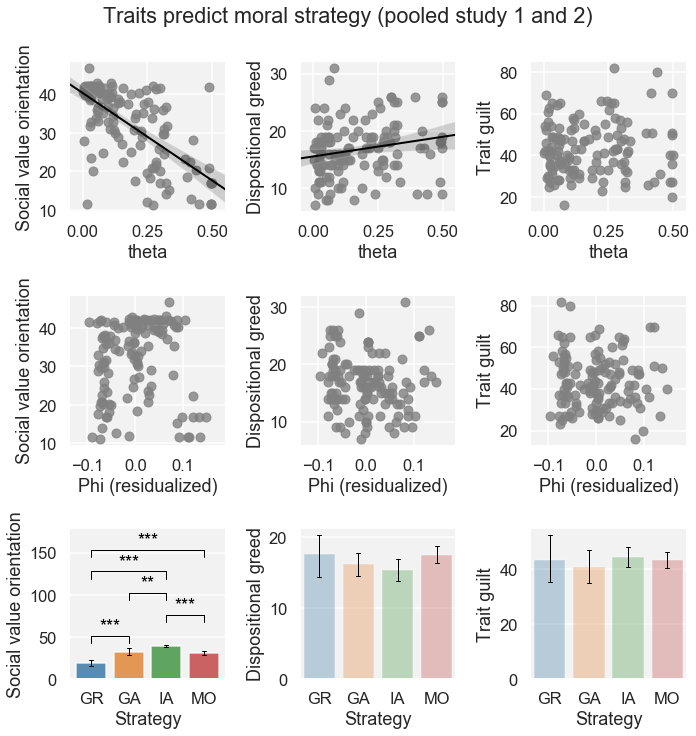

In [31]:
FigureTools.mydesign(context='talk')
fig, ax = plt.subplots(3,3,figsize=[10,10])
longNames = {'SVO':'Social value orientation','DG':'Dispositional greed','TG':'Trait guilt'}
for paramInd,parameter in enumerate(['theta','phi']):
    for metricInd,metric in enumerate(['SVO','DG','TG']):
        if parameter == 'phi':
            paramChoice = 'Phi (residualized)'
        else:
            paramChoice = parameter
        stats = scipy.stats.pearsonr(params_use[paramChoice],params_use[metric])
        if stats[1] < 0.05:
            linestyle = '-'
            color = 'k'
            linewidth = 2
        else:
            linestyle = ':'
            color = 'grey'
            linewidth = 0
        sns.regplot(data=params_use,x=paramChoice,y=metric,ax=ax[paramInd,metricInd],fit_reg=(stats[1] < 0.05),
                    color='grey',line_kws={'color':color,'linestyle':linestyle, 'linewidth':linewidth})
        print ('%s with %s: r = %.2f, p = %.4f'%(parameter,metric,stats[0],stats[1]))
        ax[paramInd,metricInd].set(ylabel=longNames[metric])
groupList = ['GR','GA','IA','MO']
longNames = {'SVO':'Social value orientation','DG':'Dispositional greed','TG':'Trait guilt'}
for metricInd,metric in enumerate(['SVO','DG','TG']):
    axCur = ax[2,metricInd]
    samples = [params_use.loc[params_use['cluster']==groupList[i],metric] for i in range(len(groupList))]
    stats = scipy.stats.f_oneway(params_use.loc[params_use['cluster']==groupList[0],metric],
                                params_use.loc[params_use['cluster']==groupList[1],metric],
                                params_use.loc[params_use['cluster']==groupList[2],metric],
                                params_use.loc[params_use['cluster']==groupList[3],metric])
    if stats[1] < 0.05:
        alpha = .8
    else:
        alpha = .3
    sns.barplot(data=params_use,x='cluster',y=metric,ax=axCur,
                order = groupList,
                alpha=alpha,errwidth=1,errcolor='k',capsize=.1)
    print ('%s: F = %.2f, p = %.4f'%(metric,stats[0],stats[1]))
    axCur.set(ylabel=longNames[metric],xlabel='Strategy')
    if metric == 'SVO':
        sampleCouples = [[0,1],[2,3],[1,2],[0,2],[0,3],[1,3]]
        signCouples = list()
        for couple in sampleCouples:
            stats = scipy.stats.ttest_ind(samples[couple[0]],samples[couple[1]])
            df = len(samples[couple[0]])+len(samples[couple[1]])-1
            print ('%s with %s: t(%i) = %.2f, p = %.4f, p_corr = %.4f'%(
                groupList[couple[0]],groupList[couple[1]],df,
                stats[0],stats[1],stats[1]*len(sampleCouples)))
            if (stats[1]*len(sampleCouples)) < 0.05:
                signCouples = signCouples+[np.hstack([couple,stats[1]*len(sampleCouples)])]
        FigureTools.add_sig_markers(axCur,relationships=signCouples,distScale=2)
plt.tight_layout()
plt.suptitle('Traits predict moral strategy (pooled study 1 and 2)',y=1.03)
plt.show()

In [33]:
for metricInd,metric in enumerate(['SVO','DG','TG']):
        stats = scipy.stats.pearsonr(phi_resid,params_use[metric])
        print (stats)

(0.030017565682370583, 0.7355955453627399)
(-0.10852255682906761, 0.2208763053524466)
(-0.04502718826312126, 0.6123724197691289)
